# Predicting Count of Total Rental Bikes Using KNN Regression
Authors: Cindy Jin, Linda Huang, Davis Li

In [1]:
library(tidyverse)
library(ggplot2)
library(readxl)
library(digest)
library(dplyr)
library(repr)
library(tidymodels)
library(GGally)
options(repr.matrix.max.rows = 10)

set.seed(123)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.3     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.1.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

# Summary
We are going to build a regression model using the k-nearest neighbors algorithm. We will use three features: wind speed, normalized feeling temperature and season to predict the count of total rental bikes. This model could help the sharing-bike companies to better understand the distribution of the need for bikes and encourage people to support public transportation. 


!!!!!Our current model has a prediction error, as measured by root mean square prediction error (RMSPE), of about $70. This model, is useful, however it could use some improvement given that the nightly prices in our data set range from $0-$1000, and the median nightly price is $119.

The data we used to build our model contains all the active Airbnb listings for Vancouver, Canada from April 2021. The data was collected from http://insideairbnb.com/.

# Introduction
- provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
- clearly state the question you tried to answer with your project
- identify and describe the dataset that was used to answer the question

# Methods
### Data
The data set used in this project has originally 16 columns and 731 rows...

!!!!!! 74 characteristics from active AirBnB short-term rental units from Vancouver, Canada, as well as the property's nightly price collected during April 2021 from http://insideairbnb.com/. Using domain expertise, we chose to focus on 10 predictor variables (Table 1).

Table 1. Predictor variables used for analysis, chosen for their utility by domain expertise.

Predictor variable	Description
host_response_rate	Percentage of new inquiries and reservation requests the host responded to (by either accepting/pre-approving or declining) within 24 hours
host_acceptance_rate	Percentage of reservation requests the host accepts
latitude	Measure of location north or south of the Equator
longitude	Measure of location east or west of the prime meridian at Greenwich, London, England
bedrooms	Number of bedrooms in the rental unit
beds	Number of beds in the rental unit
accommodates	Maximum number of guests the rental unit can accommodate
minimum_nights	Minimum number of nights a guests must stay to be able to reserve the rental unit
review_scores_rating	Review score of the property
number_of_reviews	Number of reviews
Data cleaning was performed to remove properties with no reviews (as some of our predictor variables were constructed from reviews), remove data with missing values, as remove special characters (percent symbols and currency symbols) from predictor variables that should have been numeric, and convert that data to numeric types.

# Results
- describe in written english the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
- your report should include code which:
- loads data from the original source on the web
- wrangles and cleans the data from it’s original (downloaded) format to the format necessary for the planned classification or clustering analysis
- performs a summary of the data set that is relevant for exploratory data analysis related to the planned classification analysis
- creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned classification analysis
- performs classification or regression analysis
- creates a visualization of the result of the analysis


note: all tables and figure should have a figure/table number and a legend

In [2]:
data <- read.csv("data/day.csv", header = T)|> 
        select(-instant, -dteday, -yr, -holiday, -casual, -registered)
head(data)

,season,mnth,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,1,1,6,0,2,0.344167,0.363625,0.805833,0.1604460,985
2,1,1,0,0,2,0.363478,0.353739,0.696087,0.2485390,801
3,1,1,1,1,1,0.196364,0.189405,0.437273,0.2483090,1349
4,1,1,2,1,1,0.200000,0.212122,0.590435,0.1602960,1562
5,1,1,3,1,1,0.226957,0.229270,0.436957,0.1869000,1600
6,1,1,4,1,1,0.204348,0.233209,0.518261,0.0895652,1606


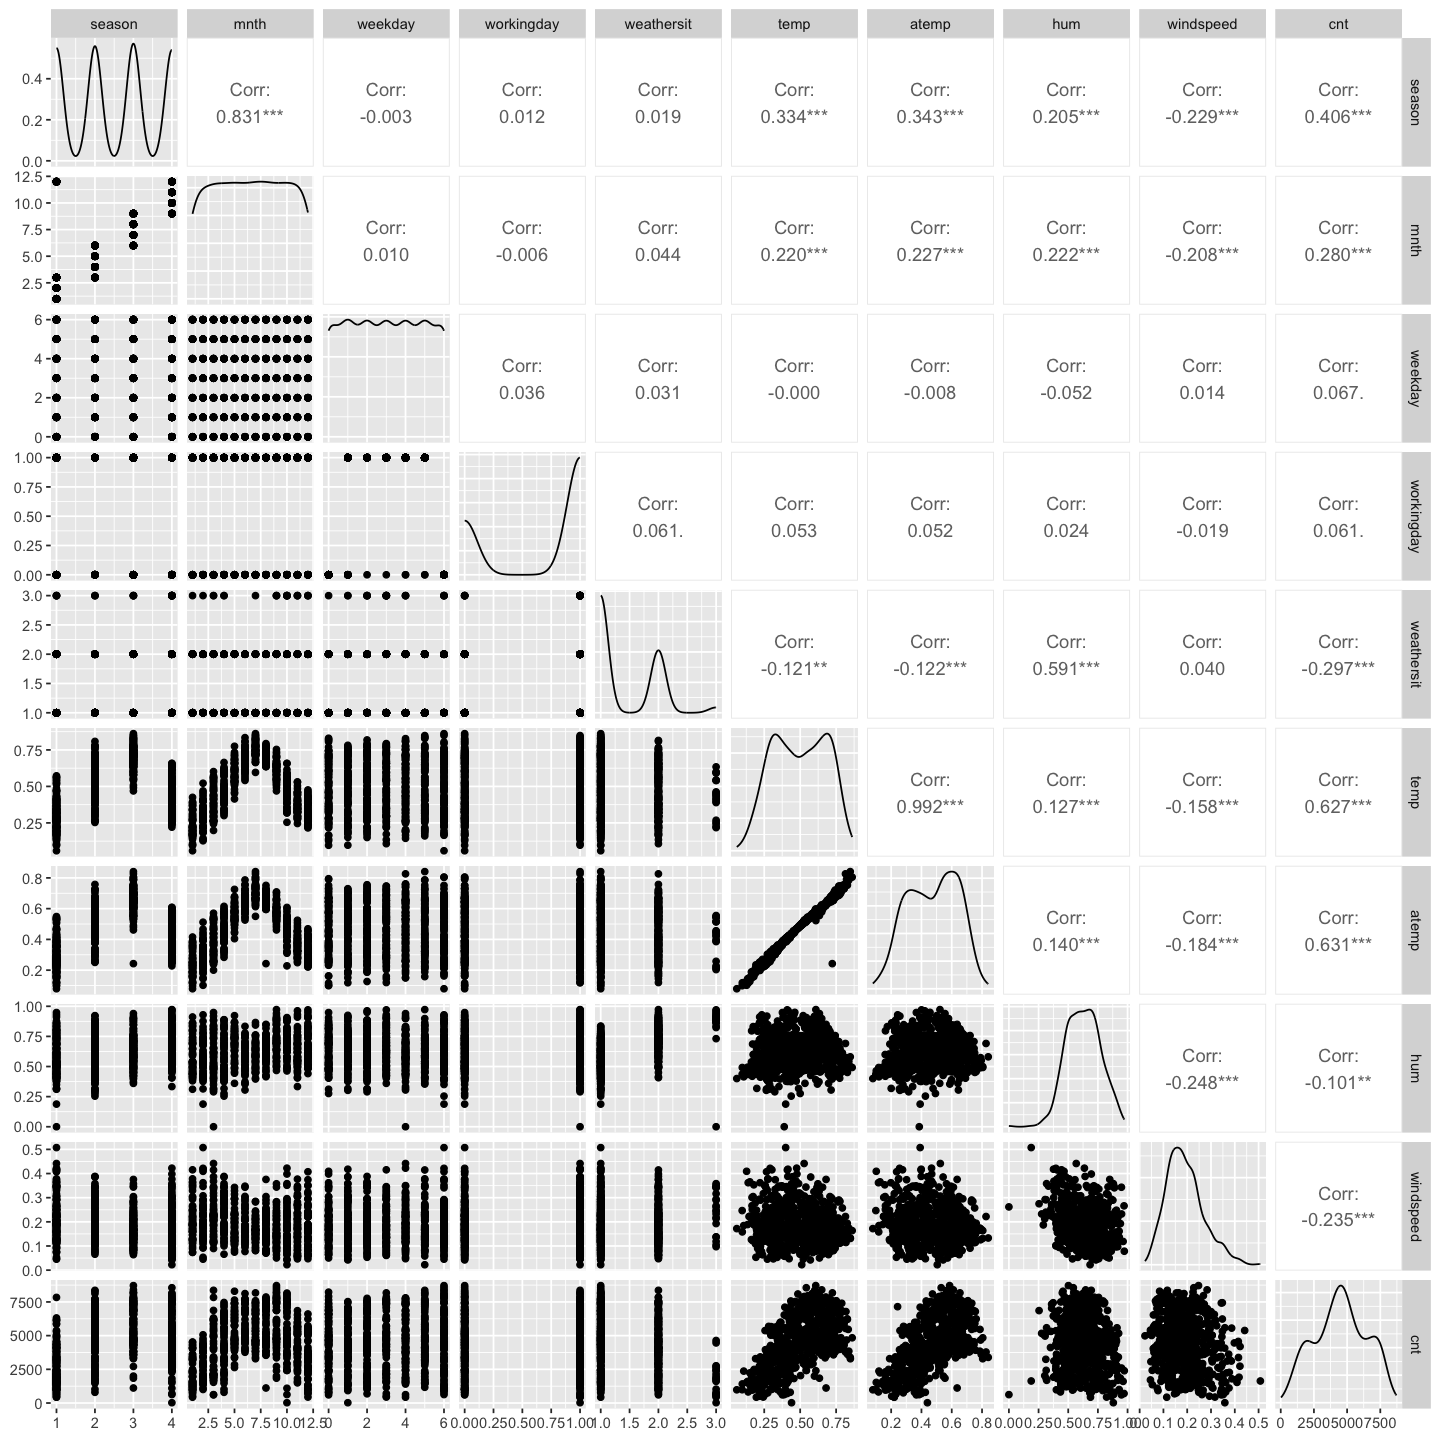

In [3]:
options(repr.plot.width = 12, repr.plot.height = 12)    
ggpairs(data)

In [4]:
training <- sample_n(data, nrow(data)*0.8, replace = FALSE)
testing <- anti_join(data, training)

Joining with `by = join_by(season, mnth, weekday, workingday, weathersit, temp,
atemp, hum, windspeed, cnt)`


In [5]:
recipe <- recipe(cnt ~ windspeed+atemp+season, data = training) %>%   
                step_scale(all_predictors()) %>%  
                step_center(all_predictors()) 

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%  
             set_engine("kknn") %>%      
             set_mode("regression")  

vfold <- vfold_cv(training, v = 5, strata = cnt)   

gridvals <- tibble(neighbors = seq(from = 1, to = 20))  

wkflw <- workflow() %>%                              
             add_recipe(recipe) %>%                  
             add_model(knn_spec)                     

results <- wkflw  %>%
           tune_grid(resamples = vfold, grid = gridvals)  %>%
           collect_metrics() %>%          
           filter(.metric == "rmse")%>%      
           arrange(mean)              
head(results, 5)

kmin <- results %>%           
        slice(1) %>%          
        pull(neighbors) 

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
17,rmse,standard,1388.472,5,30.88315,Preprocessor1_Model17
18,rmse,standard,1389.657,5,30.11784,Preprocessor1_Model18
19,rmse,standard,1389.991,5,31.02894,Preprocessor1_Model19
20,rmse,standard,1390.159,5,30.11912,Preprocessor1_Model20
16,rmse,standard,1391.034,5,30.85699,Preprocessor1_Model16


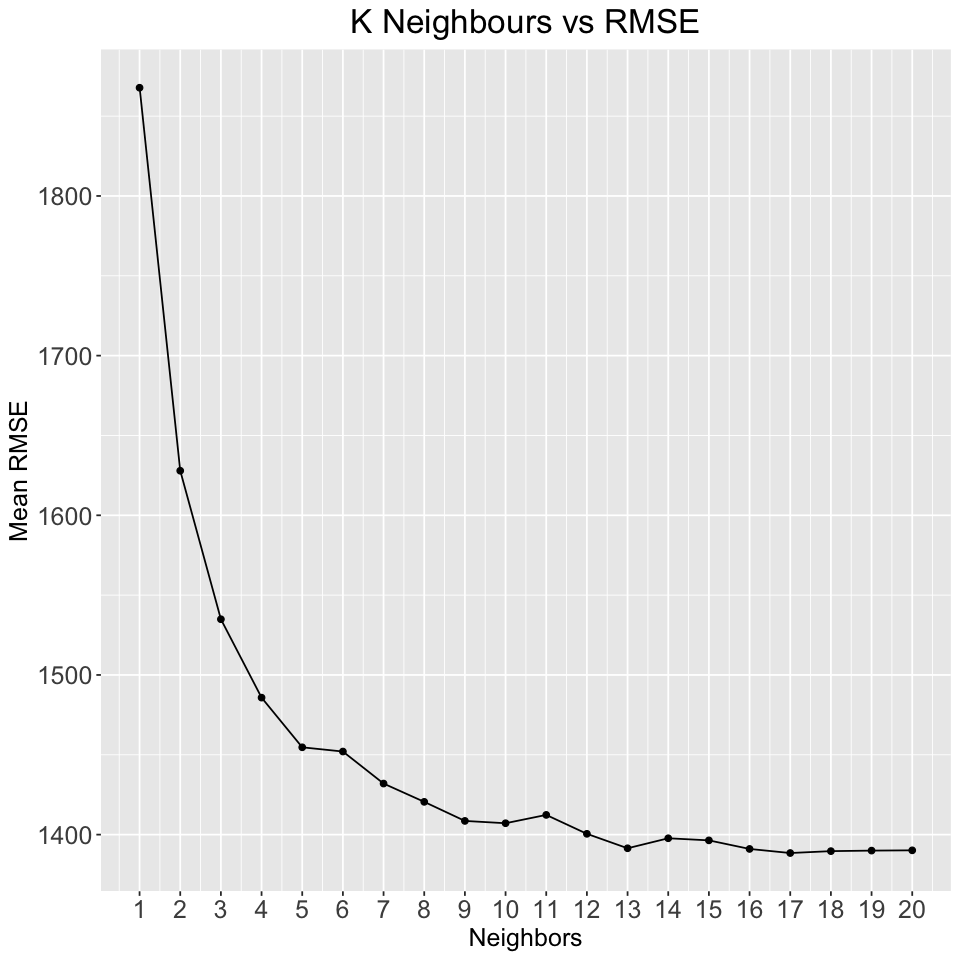

In [6]:
options(repr.plot.width = 8, repr.plot.height = 8)                 
accuracy_vs_k <- ggplot(results, aes(x = neighbors, y = mean)) +     
                 geom_point() + geom_line() +                        
                 labs(x = "Neighbors", y = "Mean RMSE") +    
                 scale_x_continuous(breaks = seq(0, 20, by = 1)) +   
                 ggtitle("K Neighbours vs RMSE") +                 
                 theme(axis.title.x = element_text(size = 15),       
                       axis.text.x = element_text(size = 15),
                       axis.text.y = element_text(size = 15),
                       axis.title.y = element_text(size = 15),
                       plot.title = element_text(size = 20, hjust = 0.5))

accuracy_vs_k

In [7]:
knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) %>%      
              set_engine("kknn") %>%      
              set_mode("regression")

knn_fit <- workflow() %>%      
           add_recipe(recipe) %>%             
           add_model(knn_spec_2) %>%          
           fit(data = training)       

predictions <- knn_fit %>%                   
               predict(testing) %>%  
               bind_cols(testing)    

summary <- predictions %>%
           metrics(truth = cnt, estimate = .pred) %>%  
           filter(.metric == "rmse")%>%                       
           select(.estimate)                                     
summary

.estimate
<dbl>
1483.132


# Discussion
- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

# References
at least 4 citations relevant to the project (format is your choose, just be consistent across the references).